<a href="https://colab.research.google.com/github/Aditya2600/Music-Recommendation-System/blob/main/Spotify_Recommendation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install seaborn

In [2]:
!pip install scikit-surprise

In [3]:
!pip install implicit

In [4]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

# Standard libraries
import os
import sys
import gc
import warnings
import random
import time
from timeit import default_timer as timer
from collections import defaultdict

# Numerical & Data Handling
import numpy as np
import pandas as pd
import scipy.sparse as sparse

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# Machine Learning & Recommendation Libraries
import implicit
from tqdm.notebook import tqdm
from surprise import KNNWithMeans, KNNBasic, KNNWithZScore, Dataset, accuracy, Reader

# Suppress Warnings
warnings.filterwarnings("ignore")

# IPython settings for better interactive display
InteractiveShell.ast_node_interactivity = "all"

# Pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Jupyter Notebook Styling
display(HTML(data="""<style> div.notebook-container { width:95%; } </style>"""))

# ✅ Corrected Plotting Styles
init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')  # Matplotlib built-in style
sns.set(context="notebook", palette="dark", style='whitegrid', color_codes=True)

# NumPy print settings
np.set_printoptions(precision=5, suppress=True)

# Get the current working directory
path_main = os.getcwd()

# Print confirmation
print("✅ Environment setup complete!")

✅ Environment setup complete!


In [5]:
# File path for the dataset
lastfm_plays_file = '/content/usersha1-artmbid-artname-plays.tsv'

# Load the dataset
df = pd.read_csv(
    lastfm_plays_file,  # Corrected variable name
    delimiter="\t",  # Corrected delimiter
    header=None,
    usecols=[0, 2, 3],  # Fixed brackets and indices
    names=['userId', 'artistName', 'listens']  # Fixed incorrect quotes
)

# Get unique users and artists
artists_list = list(df['artistName'].unique())
users_list = list(df['userId'].unique())

# Display first 2 rows
display(df.head(2))

# Print dataset details
print(f'{df.shape[0]} user-artist interactions')
print(f'Number of unique users - {len(users_list)}')
print(f'Number of unique artists - {len(artists_list)}')
print('We can see that we have ~175 million records from interactions')
print('We can also see that we have far more users than there are artists')

,userId,artistName,listens
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137.0
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099.0


1342014 user-artist interactions
Number of unique users - 27247
Number of unique artists - 92024
We can see that we have ~175 million records from interactions
We can also see that we have far more users than there are artists


In [6]:
# User summary
user_sum = df.groupby("userId").agg({'artistName': ['nunique'], 'listens': 'sum'}).reset_index()
user_sum.columns = ['userId', 'nA_listen', 'n_listens']
user_sum = user_sum.sort_values('nA_listen', ascending=False).reset_index(drop=True)

# Artist summary
artist_sum = df.groupby('artistName').agg({'userId': ['nunique'], 'listens': 'sum'}).reset_index()
artist_sum.columns = ['artistName', 'nU_listen', 'n_listens']
artist_sum = artist_sum.sort_values('nU_listen', ascending=False).reset_index(drop=True)

In [7]:
def filter_lastfm_raw(df, user_sum, artist_sum, user_t=25, artist_t=25):
    """
    Function to filter users and artists based on thresholds.
    - user_t: Minimum number of artists a user must have listened to.
    - artist_t: Minimum number of users that must have listened to an artist.
    """

    # Filter users and artists based on thresholds
    users_req = user_sum[user_sum['nA_listen'] > artist_t]['userId'].tolist()
    artists_req = artist_sum[artist_sum['nU_listen'] > user_t]['artistName'].tolist()

    # Create a copy of the original dataframe
    df_main = df.copy()

    # Create user and artist flags
    df_main['user_flag'] = df_main['userId'].isin(users_req)
    df_main['artist_flag'] = df_main['artistName'].isin(artists_req)

    # Filter the dataframe
    df_main = df_main[df_main['user_flag'] & df_main['artist_flag']]

    # Print statistics
    print(f"# Users after filtering: {len(users_req)}")
    print(f"# Artists after filtering: {len(artists_req)}")

    # Keep only relevant columns
    df_als = df_main[['userId', 'artistName', 'listens']].copy()

    # Splitting into train and test sets
    df_als['split'] = None
    test_idx = df_als.groupby("userId")["artistName"].sample(frac=0.3, random_state=2047).index
    df_als.loc[test_idx, 'split'] = 'Test'
    df_als.loc[df_als['split'].isna(), 'split'] = 'Train'

    # Convert categorical columns for implicit modeling
    df_als['userId'] = df_als['userId'].astype("category")
    df_als['artistName'] = df_als['artistName'].astype("category")

    df_als['user_ID'] = df_als['userId'].cat.codes
    df_als['artist_ID'] = df_als['artistName'].cat.codes

    # Get unique sorted users and artists after filtering
    users_als = sorted(df_als['userId'].unique().tolist())
    artists_als = sorted(df_als['artistName'].unique().tolist())

    # Display sample data
    print(df_als.head())

    # Sample users and artists
    print("Sample users:", users_als[:5])
    print("Sample artists:", artists_als[2037:2047])
    print(' ')

    df_als_train = df_als[df_als['split'] == 'Train']

    # Free up memory
    for _ in range(2):
        gc.collect()

    # Create sparse matrix (User-Item Matrix)
    sparse_item_user = sparse.csr_matrix((
        df_als_train['listens'].astype(float),  # Data (listens count)
        (df_als_train['user_ID'].values, df_als_train['artist_ID'].values)  # Row (user) and column (artist)
    ))

    # Define whether to pivot the matrix (User-Item or Item-User)
    pivot_user_item_for_item_user = True

    if pivot_user_item_for_item_user:
        sparse_user_item = sparse_item_user.T.tocsr()  # Transpose for Item-User matrix
    else:
        sparse_user_item = sparse_item_user  # Keep as User-Item matrix

    return df_als, df_als_train, sparse_user_item


# ✅ **Correct Function Call**
# Ensure that df, user_sum, and artist_sum are defined before calling the function
df_als, df_als_train, sparse_user_item = filter_lastfm_raw(df, user_sum, artist_sum)

# Print confirmation
print("Processing complete! Filtered dataset and sparse matrix are ready.")

# Users after filtering: 26820
# Artists after filtering: 7150
                                     userId             artistName  listens  \
1  00000c289a1829a808ac09c00daf10bc3c4e223b              die Ärzte   1099.0   
2  00000c289a1829a808ac09c00daf10bc3c4e223b      melissa etheridge    897.0   
3  00000c289a1829a808ac09c00daf10bc3c4e223b              elvenking    717.0   
4  00000c289a1829a808ac09c00daf10bc3c4e223b   juliette & the licks    706.0   
5  00000c289a1829a808ac09c00daf10bc3c4e223b  red hot chili peppers    691.0   

   split  user_ID  artist_ID  
1  Train        0       1777  
2   Test        0       4168  
3  Train        0       2090  
4  Train        0       3357  
5  Train        0       5151  
Sample users: ['00000c289a1829a808ac09c00daf10bc3c4e223b', '00001411dc427966b17297bf4d69e7e193135d89', '00004d2ac9316e22dc007ab2243d6fcb239e707d', '000063d3fe1cf2ba248b9e3c3f0334845a27a6bf', '00007a47085b9aab8af55f52ec8846ac479ac4fe']
Sample artists: ['el canto del loco', 'el

In [8]:
# Call the function to get the filtered and split data
df_als_train = filter_lastfm_raw(df, user_sum, artist_sum) # Assuming df, user_sum, artist_sum are defined

# Users after filtering: 26820
# Artists after filtering: 7150
                                     userId             artistName  listens  \
1  00000c289a1829a808ac09c00daf10bc3c4e223b              die Ärzte   1099.0   
2  00000c289a1829a808ac09c00daf10bc3c4e223b      melissa etheridge    897.0   
3  00000c289a1829a808ac09c00daf10bc3c4e223b              elvenking    717.0   
4  00000c289a1829a808ac09c00daf10bc3c4e223b   juliette & the licks    706.0   
5  00000c289a1829a808ac09c00daf10bc3c4e223b  red hot chili peppers    691.0   

   split  user_ID  artist_ID  
1  Train        0       1777  
2   Test        0       4168  
3  Train        0       2090  
4  Train        0       3357  
5  Train        0       5151  
Sample users: ['00000c289a1829a808ac09c00daf10bc3c4e223b', '00001411dc427966b17297bf4d69e7e193135d89', '00004d2ac9316e22dc007ab2243d6fcb239e707d', '000063d3fe1cf2ba248b9e3c3f0334845a27a6bf', '00007a47085b9aab8af55f52ec8846ac479ac4fe']
Sample artists: ['el canto del loco', 'el

In [15]:
# Function to filter dataset
def filter_lastfm_raw(df, user_sum, artist_sum, user_t=25, artist_t=25):
    """Filter users and artists based on thresholds."""

    users_req = user_sum[user_sum['nA_listen'] > artist_t]['userId'].tolist()
    artists_req = artist_sum[artist_sum['nU_listen'] > user_t]['artistName'].tolist()

    df_main = df.copy()
    df_main['user_flag'] = df_main['userId'].isin(users_req)
    df_main['artist_flag'] = df_main['artistName'].isin(artists_req)
    df_main = df_main[df_main['user_flag'] & df_main['artist_flag']]

    df_als = df_main[['userId', 'artistName', 'listens']].copy()
    df_als['split'] = None

    # Train-Test Split
    test_idx = df_als.groupby("userId")["artistName"].sample(frac=0.3, random_state=2047).index
    df_als.loc[test_idx, 'split'] = 'Test'
    df_als.loc[df_als['split'].isna(), 'split'] = 'Train'

    # Convert to categorical codes for MF training
    df_als['userId'] = df_als['userId'].astype("category")
    df_als['artistName'] = df_als['artistName'].astype("category")
    df_als['user_ID'] = df_als['userId'].cat.codes
    df_als['artist_ID'] = df_als['artistName'].cat.codes

    # ✅ Define users_als and artists_als
    users_als = sorted(df_als['user_ID'].unique().tolist())  # Fix: Using user_ID
    artists_als = sorted(df_als['artist_ID'].unique().tolist())  # Fix: Using artist_ID

    df_als_train = df_als[df_als['split'] == 'Train']

    # Free memory
    gc.collect()

    # Create Sparse Matrix (User-Item)
    sparse_item_user = sparse.csr_matrix((
        df_als_train['listens'].astype(float).values,
        (df_als_train['user_ID'].values, df_als_train['artist_ID'].values)
    ))

    sparse_user_item = sparse_item_user.T.tocsr()  # Transposed for Item-User Matrix

    return df_als, df_als_train, sparse_user_item, users_als, artists_als

# ✅ Correct function call
df_als, df_als_train, sparse_user_item, users_als, artists_als = filter_lastfm_raw(df, user_sum, artist_sum)

# Combine user_id based on the index used for MF training with original users
user_id_dict = df_als[['userId', 'user_ID']].drop_duplicates().reset_index(drop=True)

# ✅ Fixing NameError: Now users_als is properly defined!
user_id_dict['trained_user'] = np.where(user_id_dict['user_ID'].isin(users_als), True, False)

# Combine artist_id based on the index used for MF training with original artists
artist_id_dict = df_als[['artist_ID', 'artistName']].drop_duplicates().reset_index(drop=True)

# ✅ Function to compute precision and recall
def pak(y_true, y_pred, k=10):
    """
    Compute precision and recall at k.
    """
    precisions = []
    recalls = []

    for i, preds in enumerate(y_pred):
        relevant_items = [p for p in preds[:k] if p in y_true[i]]
        precision = (len(relevant_items) * 100) / k if k > 0 else 0
        precisions.append(precision)

        recall = (len(relevant_items) * 100) / len(y_true[i]) if len(y_true[i]) > 0 else 0
        recalls.append(recall)

    return precisions, recalls

In [23]:
# ✅ Call the function correctly
df_als, df_als_train, sparse_user_item, users_als, artists_als = filter_lastfm_raw(df, user_sum, artist_sum)

# ✅ Initialize ALS Model
model = implicit.als.AlternatingLeastSquares(
    factors=100,
    regularization=0.1,
    iterations=50,
    num_threads=0
)

# ✅ Convert sparse matrix to confidence matrix
df_als_conf = (sparse_user_item * 10).astype(np.float64)

# ✅ Train the model
model.fit(df_als_conf)

  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
# ✅ Recommendation Process
n_rec = 100  # Number of top recommendations

# ✅ Fixed variable: Using 'user_ID' instead of 'user_TD'
users_to_rec = list(user_id_dict[user_id_dict['trained_user']]['user_ID'].values[:1080])

# ✅ Fixed typo in function name
als_rec_artists = model.recommend(users_to_rec, sparse_user_item[users_to_rec, :], n_rec, filter_already_liked_items=True)

# ✅ Convert predictions and true values into lists
y_pred_als = als_rec_artists[0].tolist()

# ✅ Fixed incorrect syntax for filtering test set
y_true_als = df_als[df_als['split'] == 'Test'].groupby('user_ID')['artist_ID'].apply(list).reindex(users_to_rec, fill_value=[]).tolist()

# ✅ Compute metrics
precisions_als, recalls_als = pak(y_true_als, y_pred_als, k=50)

# ✅ Display metrics
print(f"Precision@50: {np.mean(precisions_als):.2f}%")
print(f"Recall@50: {np.mean(recalls_als):.2f}%")

Precision@50: 0.05%
Recall@50: 0.25%


Text(0.5, 0.98, 'CF MF')

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Precision by User')

Text(0.5, 1.0, 'Recall by User')

📊 Metrics for MF-based CF:
🔹 Average Precision: 0.053703703703703705
🔹 Average Recall: 0.2538788372121705


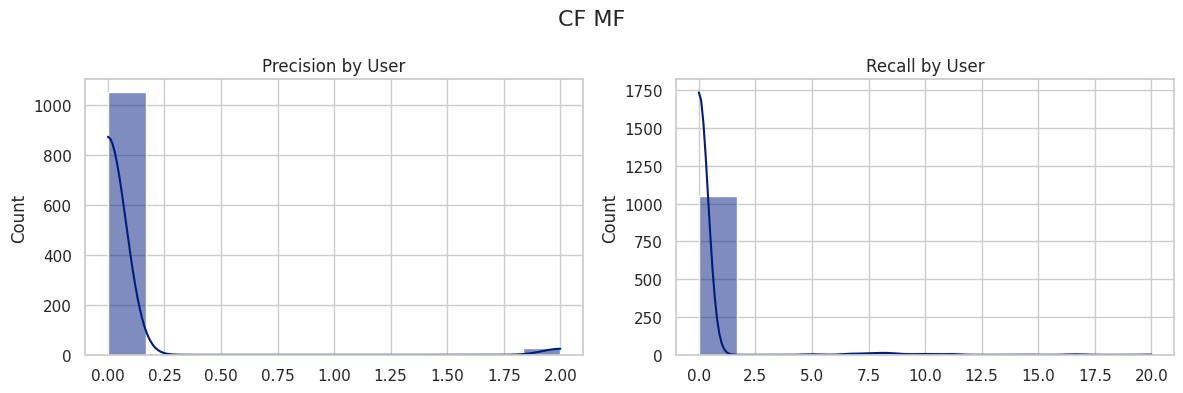

In [25]:
# ✅ Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("CF MF", fontsize=16)  # ✅ Fix `fig-suptitle` → `fig.suptitle`

# ✅ Plot precision and recall distributions
sns.histplot(precisions_als, ax=ax[0], kde=True)  # ✅ `distplot` is deprecated, use `histplot`
sns.histplot(recalls_als, ax=ax[1], kde=True)

# ✅ Set titles
ax[0].set_title("Precision by User")  # ✅ Fix `ax[®]` → `ax[0]`
ax[1].set_title("Recall by User")  # ✅ Fix `ax[1]-set_title` → `ax[1].set_title`

# ✅ Adjust layout
fig.tight_layout()

# ✅ Print metrics
print("📊 Metrics for MF-based CF:")
print("🔹 Average Precision:", np.mean(precisions_als))
print("🔹 Average Recall:", np.mean(recalls_als))